# KE5105 - Building Electrical Consumption Forecasting

# ETL 9 - Explore BTU Data

## Findings

* Negative aggregate BTU values due to attribute BTU values of zero need to be replaced with NaN.
* There are valid aggregate BTU values which are zero.
* Some zero attribute BTU values produce :
	* aggregate BTU values which are anomalous relative to neighbouring values (such values cannot be easily detected automatically)
	* extreme outlier aggregate BTU values (to be removed using an outlier removal method)

## Load libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import numpy as np
import myUtilities as mu

## Load Group 1 Building Data

In [2]:
to_load_file = open(os.path.join('source', 'other_data', 'group1_bldg_list.pickle'), 'rb')
group1_bldgs = pickle.load(to_load_file)
group1_bldgs.sort()
group1_bldgs

['AS4', 'AS5', 'CELS', 'E4', 'EA', 'MRB', 'S1A', 'SDE-1', 'SDE-2', 'SDE-3']

In [3]:
bldg_df_list = mu.load_data_by_bldg(bldg_name_list=group1_bldgs, data_type='processed')

In [4]:
bldg_df_list[0][0]

'AS4'

In [5]:
bldg_df_list[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 15 columns):
PWMAS4LanguageCenter              46165 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
BTUAS4A                           46175 non-null float64
BTUAS4B                           46175 non-null float64
BTUAS5                            46175 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
BTUAS4A_30min_avg                 46130 non-null float64
BTUAS4B_30min_avg                 46130 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46118 non-null float64
PWM_30min_avg                     46118 non-null float64
BTU_sumadd                        46130 non-null float64
BTU_sumsubtract                   46129 non-null float64
BTU_30min_avg                     46129 non-null float64
d

In [6]:
bldg_df_list[0][1].loc[:, ['PWM_30min_avg', 'BTU_30min_avg']].describe()

,PWM_30min_avg,BTU_30min_avg
count,46118.000000,46129.000000
mean,23.523150,8.631603
std,10.326996,11.851807
min,10.250000,-51.750000
25%,15.510000,0.000000
50%,18.310000,5.750000
75%,30.870000,15.820000
max,58.240000,85.200000


In [7]:
def plot_pwm_upto10_bldgs(bldg_df_list):

    nrows = int(np.ceil(len(bldg_df_list)/2))
    height = nrows * 4
    no_more_plots = False

    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(20, height))
    # list_idx = 0
    for row_idx, row in enumerate(ax):
        for col_idx, col in enumerate(row):
            if not no_more_plots:
                # Index of the (building name and dataframe) list
                bldg_idx = row_idx * len(row) + col_idx

                # Plot the time series data.
                col.plot(bldg_df_list[bldg_idx][1].loc[:, ['PWM_30min_avg', 'BTU_30min_avg']], alpha=.5)
                # col.plot(bldg_df_list[bldg_idx][1].loc[:, 'BTU_30min_avg'], alpha=.5)
                col.set_title(bldg_df_list[bldg_idx][0]+' PWM over 2015-2018')
                col.legend(bldg_df_list[bldg_idx][1].loc[:, ['PWM_30min_avg', 'BTU_30min_avg']])
                # col.legend(bldg_df_list[bldg_idx][1].loc[:, 'BTU_30min_avg'])

                if bldg_idx >= len(bldg_df_list) - 1:
                    no_more_plots = True
            else:
                col.axis('off')
    plt.show()
    return None

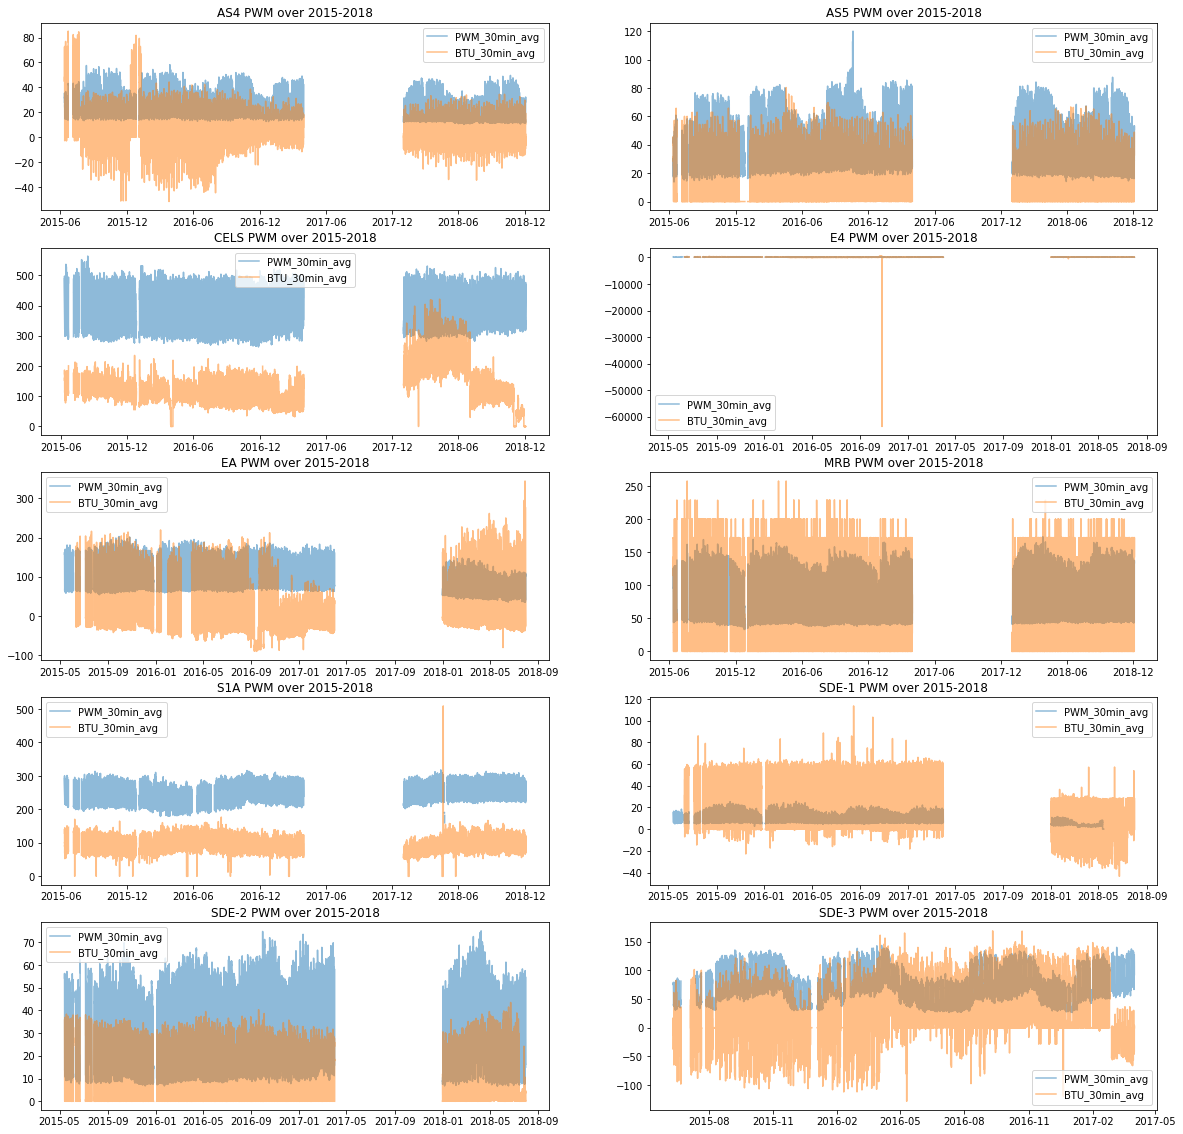

In [8]:
plot_pwm_upto10_bldgs(bldg_df_list)

There are negative BTU values for some buildings - AS4, E4, EA, SDE-1, SDE-3 (error in formula).

## AS4

In [9]:
cols = [ i for i in bldg_df_list[0][1].columns if 'BTU' in i ]
bldg_df_list[0][1].loc[:, cols[:8]].describe()

,BTUAS4A,BTUAS4B,BTUAS5,BTUAS4A_30min_avg,BTUAS4B_30min_avg,BTUAS5_30min_avg,BTU_sumadd,BTU_sumsubtract
count,46175.000000,4.617500e+04,4.617500e+04,46130.000000,46130.000000,46129.000000,46130.000000,46129.000000
mean,654285.833903,2.499622e+06,5.547989e+05,6.530181,19.077818,16.975890,25.607999,16.975890
std,122470.875799,3.470355e+05,3.720493e+05,6.919788,19.067564,16.826888,25.726494,16.826888
min,462807.500000,1.909036e+06,3.991990e+03,0.000000,0.000000,0.000000,0.000000,0.000000
25%,548492.685000,2.203356e+06,2.039742e+05,0.000000,2.750000,0.290000,2.750000,0.290000
50%,630368.630000,2.439835e+06,6.338035e+05,5.430000,5.750000,11.430000,8.750000,11.430000
75%,784673.190000,2.867112e+06,8.439908e+05,12.570000,34.500000,32.570000,48.175000,32.570000
max,856300.940000,3.063057e+06,1.156046e+06,26.620000,114.380000,80.370000,137.250000,80.370000


In [10]:
bldg_df_list[0][1].loc[:, cols[8:]].describe()

,BTU_30min_avg
count,46129.000000
mean,8.631603
std,11.851807
min,-51.750000
25%,0.000000
50%,5.750000
75%,15.820000
max,85.200000


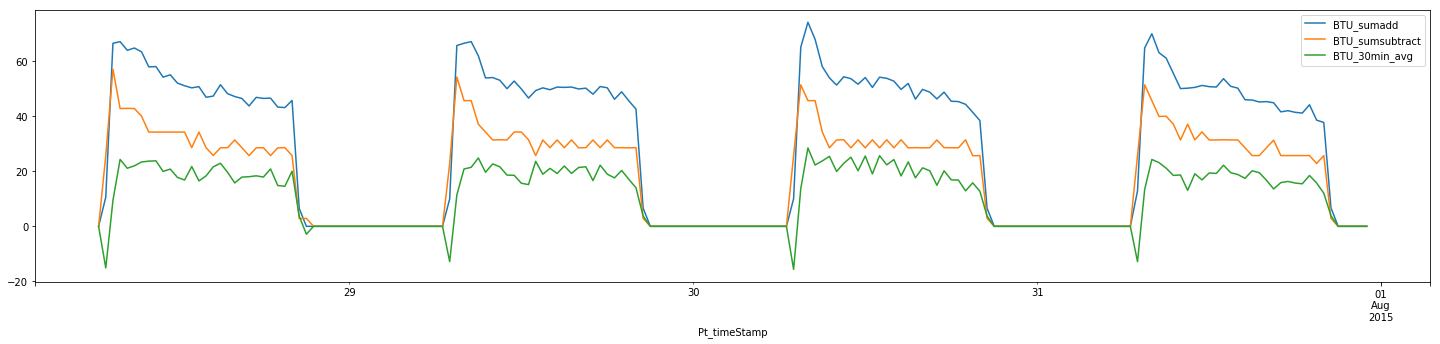

In [11]:
bldg_df_list[0][1].loc['2015-07-28 00:00:00':'2015-07-31 23:30:00', ['BTU_sumadd', 'BTU_sumsubtract', 'BTU_30min_avg']].plot(figsize=(25, 5))

### 28 Jul 2015 Data

In [12]:
bldg_df_list[0][1].loc['2015-07-28 00:00:00':'2015-07-28 23:30:00', ['BTUAS4A_30min_avg', 'BTUAS4B_30min_avg', 'BTUAS5_30min_avg', 'BTU_sumadd', 'BTU_sumsubtract', 'BTU_30min_avg']]

,BTUAS4A_30min_avg,BTUAS4B_30min_avg,BTUAS5_30min_avg,BTU_sumadd,BTU_sumsubtract,BTU_30min_avg
Pt_timeStamp,,,,,,
2015-07-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
bldg_df_list[0][1].loc['2015-07-28 00:00:00':'2015-07-28 23:30:00', ['BTUAS4A', 'BTUAS4B', 'BTUAS5', 'BTUAS4A_30min_avg', 'BTUAS4B_30min_avg', 'BTUAS5_30min_avg']]

,BTUAS4A,BTUAS4B,BTUAS5,BTUAS4A_30min_avg,BTUAS4B_30min_avg,BTUAS5_30min_avg
Pt_timeStamp,,,,,,
2015-07-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-28 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN


At 7:00 (above), the cumulative BTU values are observed again (previously NaN), the first differenced BTU values produced an aggregate negative BTU. At 21:00, as the cumulative BTU becomes constant, the aggregate BTU becomes negative before converging to a zero value.

### 29 Jul 2015 Data

In [14]:
bldg_df_list[0][1].loc['2015-07-29 00:00:00':'2015-07-29 23:30:00', ['BTUAS4A', 'BTUAS4B', 'BTUAS5', 'BTUAS4A_30min_avg', 'BTUAS4B_30min_avg', 'BTUAS5_30min_avg']]

,BTUAS4A,BTUAS4B,BTUAS5,BTUAS4A_30min_avg,BTUAS4B_30min_avg,BTUAS5_30min_avg
Pt_timeStamp,,,,,,
2015-07-29 00:00:00,478720.56,1987734.38,1046242.38,0.00,0.00,0.00
2015-07-29 00:30:00,478720.56,1987734.38,1046242.38,0.00,0.00,0.00
2015-07-29 01:00:00,478720.56,1987734.38,1046242.38,0.00,0.00,0.00
2015-07-29 01:30:00,478720.56,1987734.38,1046242.38,0.00,0.00,0.00
2015-07-29 02:00:00,478720.56,1987734.38,1046242.38,0.00,0.00,0.00
2015-07-29 02:30:00,478720.56,1987734.38,1046242.38,0.00,0.00,0.00
2015-07-29 03:00:00,478720.56,1987734.38,1046242.38,0.00,0.00,0.00
2015-07-29 03:30:00,478720.56,1987734.38,1046242.38,0.00,0.00,0.00
2015-07-29 04:00:00,478720.56,1987734.38,1046242.38,0.00,0.00,0.00


At 7:00 (above), the same phenomenon (negative aggregate BTU) observed the previous day is repeated.

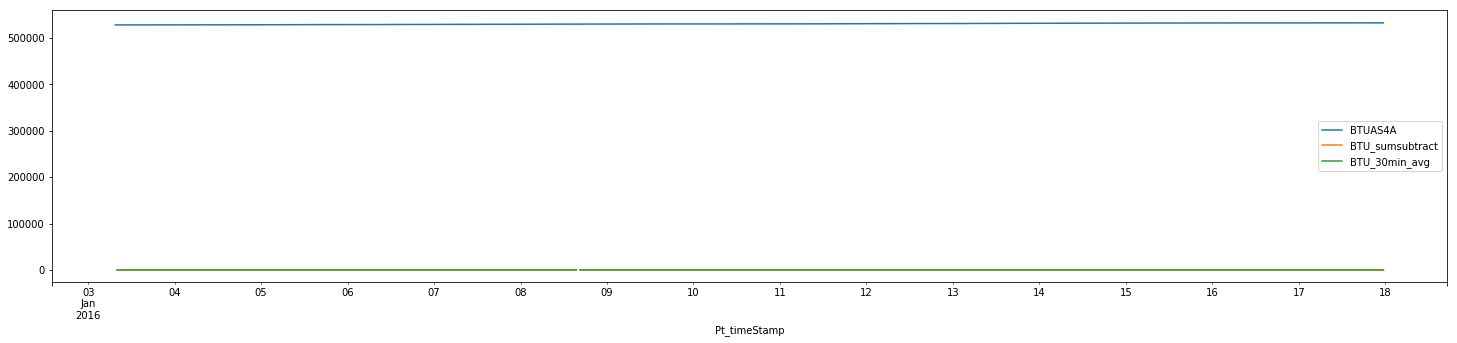

In [15]:
bldg_df_list[0][1].loc['2016-01-01 00:00:00':'2016-01-17 23:30:00', ['BTUAS4A', 'BTU_sumsubtract', 'BTU_30min_avg']].plot(figsize=(25, 5))

The differenced BTUAS55 zero values from 3-9 Jan 16 seem erroneous (above plot and below table). They produce higher than normal aggregate values for BTU.

In [16]:
bldg_df_list[0][1].loc['2016-01-04 00:00:00':'2016-01-04 23:30:00', ['BTUAS5', 'BTUAS5_30min_avg', 'BTU_sumsubtract']]

,BTUAS5,BTUAS5_30min_avg,BTU_sumsubtract
Pt_timeStamp,,,
2016-01-04 00:00:00,1156046.38,0.0,0.0
2016-01-04 00:30:00,1156046.38,0.0,0.0
2016-01-04 01:00:00,1156046.38,0.0,0.0
2016-01-04 01:30:00,1156046.38,0.0,0.0
2016-01-04 02:00:00,1156046.38,0.0,0.0
2016-01-04 02:30:00,1156046.38,0.0,0.0
2016-01-04 03:00:00,1156046.38,0.0,0.0
2016-01-04 03:30:00,1156046.38,0.0,0.0
2016-01-04 04:00:00,1156046.38,0.0,0.0


## AS5

In [17]:
bldg_df_list[1][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         46164 non-null float64
PWMEXTAS4ExBldg                   46165 non-null float64
PWMAS4LanguageCenter              46165 non-null float64
PWMCANTEEN                        46164 non-null float64
PWMStreetLight                    46164 non-null float64
BTUAS5                            46175 non-null float64
PWMMainIC_30min_avg               46117 non-null float64
PWMEXTAS4ExBldg_30min_avg         46118 non-null float64
PWMAS4LanguageCenter_30min_avg    46118 non-null float64
PWMCANTEEN_30min_avg              46117 non-null float64
PWMStreetLight_30min_avg          46117 non-null float64
BTUAS5_30min_avg                  46129 non-null float64
PWM_sumadd                        46117 non-null float64
PWM_sumsubtract                   46117 non-null float64
PWM_30min_avg                     46117 non-null float64
B

In [18]:
bldg_df_list[1][1].loc['2016-01-04 00:00:00':'2016-01-04 23:30:00', ['BTUAS5', 'BTUAS5_30min_avg', 'BTU_sumadd']]

,BTUAS5,BTUAS5_30min_avg,BTU_sumadd
Pt_timeStamp,,,
2016-01-04 00:00:00,1156046.38,0.0,0.0
2016-01-04 00:30:00,1156046.38,0.0,0.0
2016-01-04 01:00:00,1156046.38,0.0,0.0
2016-01-04 01:30:00,1156046.38,0.0,0.0
2016-01-04 02:00:00,1156046.38,0.0,0.0
2016-01-04 02:30:00,1156046.38,0.0,0.0
2016-01-04 03:00:00,1156046.38,0.0,0.0
2016-01-04 03:30:00,1156046.38,0.0,0.0
2016-01-04 04:00:00,1156046.38,0.0,0.0


The BTUAS5 values in building AS5 (above) tally with those in building AS4.

Text(0.5,1,'AS5 Cumulative BTU')

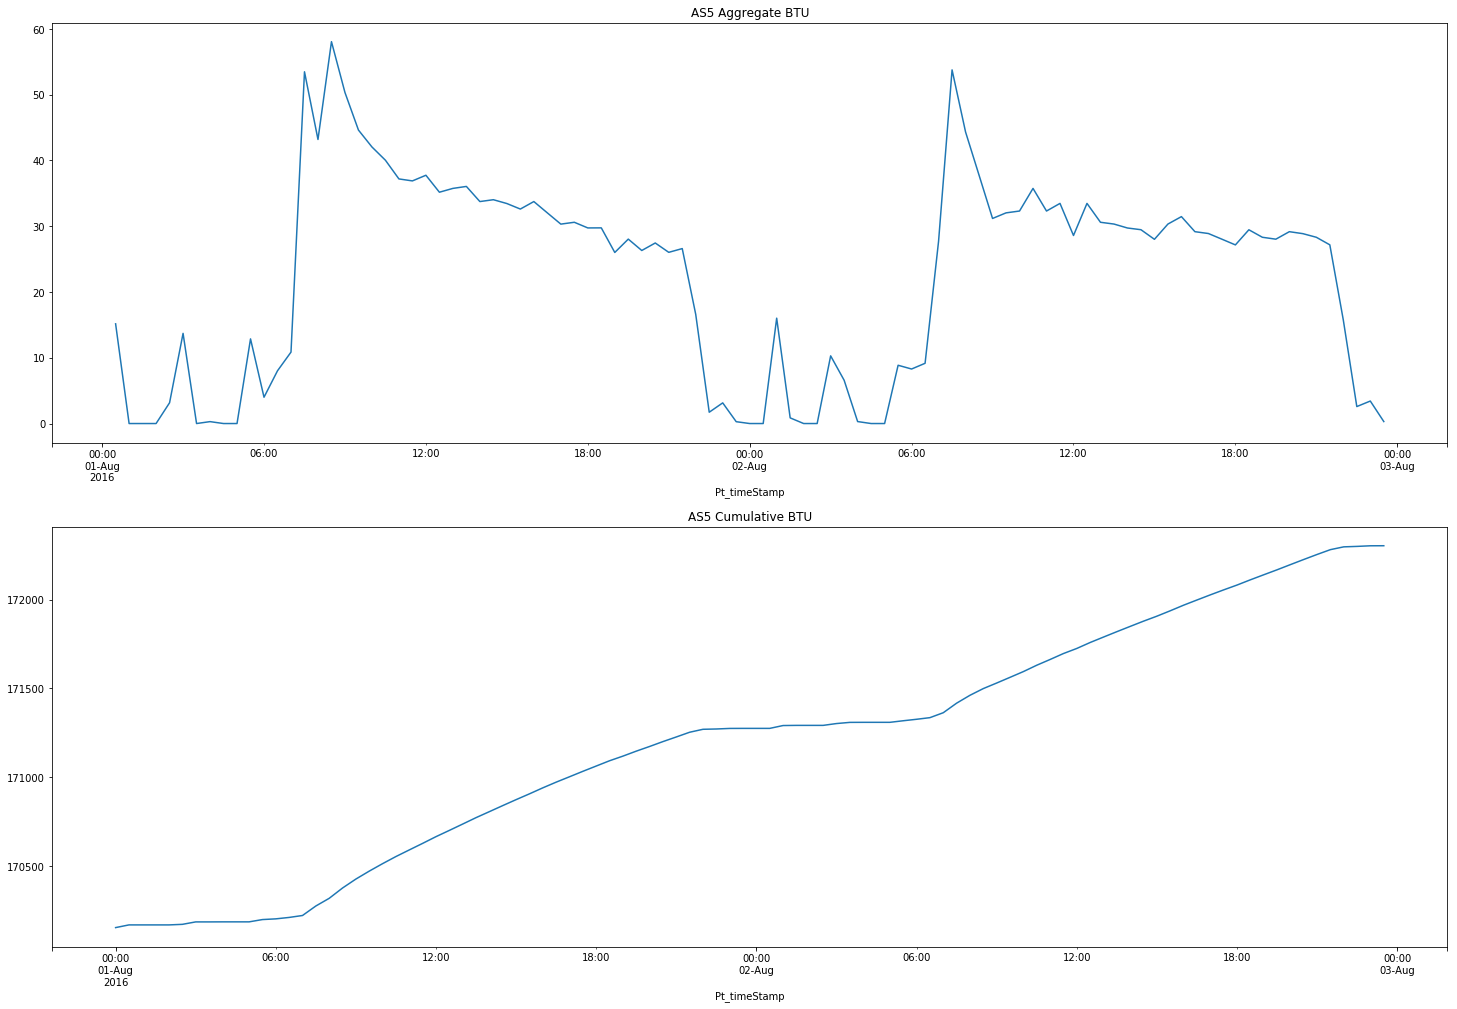

In [19]:
plt.figure(figsize=(25, 17))
plt.subplot(211)
bldg_df_list[1][1].loc['2016-08-01 00:00:00':'2016-08-02 23:30:00', 'BTU_30min_avg'].plot()
plt.title('AS5 Aggregate BTU')
plt.subplot(212)
bldg_df_list[1][1].loc['2016-08-01 00:00:00':'2016-08-02 23:30:00', 'BTUAS5'].plot()
plt.title('AS5 Cumulative BTU')

There are valid zero values in the BTU_30min_avg (below table).

In [20]:
bldg_df_list[1][1].loc['2016-08-01 00:00:00':'2016-08-01 06:00:00', ['BTUAS5', 'BTU_30min_avg']]

,BTUAS5,BTU_30min_avg
Pt_timeStamp,,
2016-08-01 00:00:00,170154.56,NaN
2016-08-01 00:30:00,170169.72,15.16
2016-08-01 01:00:00,170169.72,0.00
2016-08-01 01:30:00,170169.72,0.00
2016-08-01 02:00:00,170169.72,0.00
2016-08-01 02:30:00,170172.88,3.16
2016-08-01 03:00:00,170186.59,13.71
2016-08-01 03:30:00,170186.59,0.00
2016-08-01 04:00:00,170186.88,0.29


## E4

In [21]:
bldg_df_list[3][1].loc[:, ['PWM_30min_avg', 'BTU_30min_avg']].describe()

,PWM_30min_avg,BTU_30min_avg
count,41279.000000,40095.000000
mean,113.556209,93.168793
std,25.343343,324.195878
min,73.250000,-63612.750000
25%,91.500000,53.500000
50%,105.750000,92.750000
75%,136.500000,125.250000
max,186.500000,492.000000


In [22]:
cols = [ i for i in bldg_df_list[3][1].columns if 'BTU' in i ]
bldg_df_list[3][1].loc[:, cols[:8]].describe()

,BTUE4,BTUE4A,BTUE5,BTUEW2,BTULinkway,BTUE4_30min_avg,BTUE4A_30min_avg,BTUE5_30min_avg
count,4.019200e+04,4.020800e+04,4.018600e+04,4.020800e+04,4.019000e+04,40152.000000,40171.000000,40149.000000
mean,1.038280e+07,3.860087e+06,5.423201e+06,2.640682e+06,1.780280e+07,545.426490,40.834433,121.970746
std,6.155550e+06,6.484586e+05,2.014529e+06,1.550880e+06,3.655238e+06,132.013811,21.273974,35.465502
min,2.271718e+05,2.735287e+06,2.362372e+06,6.492000e+01,1.237890e+07,0.000000,0.000000,0.000000
25%,4.965901e+06,3.318251e+06,3.769262e+06,1.143335e+06,1.483091e+07,431.500000,30.750000,96.000000
50%,1.008844e+07,3.832320e+06,5.107172e+06,3.658672e+06,1.708875e+07,509.000000,41.750000,114.750000
75%,1.582989e+07,4.681922e+06,7.882361e+06,4.068800e+06,2.228785e+07,666.000000,58.500000,152.750000
max,2.132874e+07,4.883811e+06,9.038235e+06,4.373220e+06,2.451263e+07,940.000000,90.750000,217.000000


In [23]:
bldg_df_list[3][1].loc[:, cols[8:]].describe()

,BTUEW2_30min_avg,BTULinkway_30min_avg,BTU_sumadd,BTU_sumsubtract,BTU_30min_avg
count,40170.000000,40152.000000,40152.000000,40116.000000,40095.000000
mean,69.565587,220.069860,545.426490,452.439182,93.168793
std,48.866472,321.430986,132.013811,337.212092,324.195878
min,0.000000,0.000000,0.000000,152.000000,-63612.750000
25%,0.000000,187.000000,431.500000,363.750000,53.500000
50%,89.250000,211.000000,509.000000,444.000000,92.750000
75%,106.750000,254.000000,666.000000,523.620000,125.250000
max,191.250000,63968.000000,940.000000,64340.750000,492.000000


BTULinkway_30min_avg has a max value of 63968. Look for the value.

In [24]:
bldg_df_list[3][1].index[bldg_df_list[3][1]['BTULinkway_30min_avg'] == 63968.0]

DatetimeIndex(['2016-10-26 16:00:00'], dtype='datetime64[ns]', name='Pt_timeStamp', freq=None)

In [25]:
bldg_df_list[3][1].loc['2016-10-23 14:00:00':'2016-10-26 18:00:00', ['BTULinkway', 'BTULinkway_30min_avg']]

,BTULinkway,BTULinkway_30min_avg
Pt_timeStamp,,
2016-10-23 14:00:00,17586116.0,0.0
2016-10-23 14:30:00,17586116.0,0.0
2016-10-23 15:00:00,17586116.0,0.0
2016-10-23 15:30:00,17586116.0,0.0
2016-10-23 16:00:00,17586116.0,0.0
2016-10-23 16:30:00,17586116.0,0.0
2016-10-23 17:00:00,17586116.0,0.0
2016-10-23 17:30:00,17586116.0,0.0
2016-10-23 18:00:00,17586116.0,0.0


There is an abrupt change in the cumulative BTU value at 16:00 (above). It looks like the BTULinkway values before 16:00 were erroneous (i.e. BTULinkway_30min_avg should not be zero or the cumulative BTULinkway should not be constant).

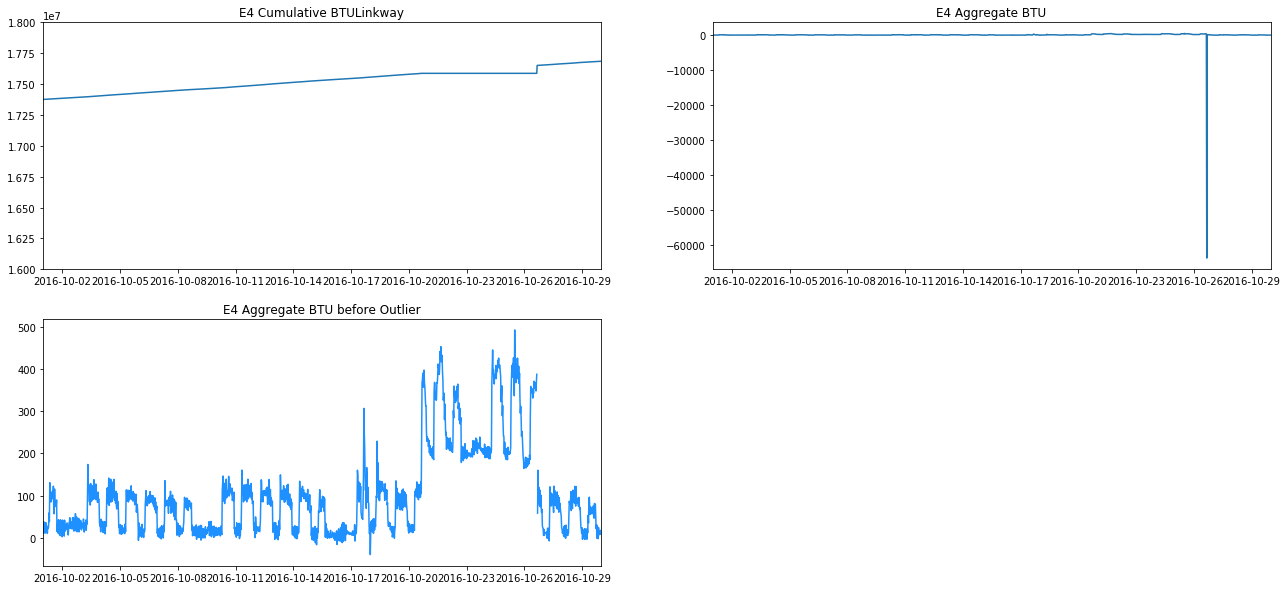

In [26]:
plt.figure(figsize=(22, 10))
plt.subplot(221)
plt.plot(bldg_df_list[3][1].loc['2016-10-01 00:00:00':'2016-10-29 23:30:00', 'BTULinkway'])
plt.title('E4 Cumulative BTULinkway')
plt.xlim('2016-10-01 00:00:00', '2016-10-29 23:30:00')
plt.ylim((16000000, 18000000))
plt.subplot(222)
plt.plot(bldg_df_list[3][1].loc['2016-10-01 00:00:00':'2016-10-29 23:30:00', 'BTU_30min_avg'])
plt.xlim('2016-10-01 00:00:00', '2016-10-29 23:30:00')
plt.title('E4 Aggregate BTU')
plt.subplot(223)
plt.plot(bldg_df_list[3][1].loc['2016-10-01 00:00:00':'2016-10-26 15:30:00', 'BTU_30min_avg'], color='dodgerblue')
plt.plot(bldg_df_list[3][1].loc['2016-10-26 16:30:00':'2016-10-29 23:30:00', 'BTU_30min_avg'], color='dodgerblue')
plt.xlim('2016-10-01 00:00:00', '2016-10-29 23:30:00')
plt.title('E4 Aggregate BTU before Outlier')
plt.show()

The aggregate BTU during the period when BTULinkway is zero looks erroneous relative to the neighbouring values.

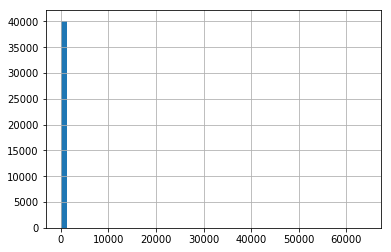

In [27]:
pd.Series.hist(bldg_df_list[3][1]['BTULinkway_30min_avg'], bins=50)

## EA

In [28]:
bldg_df_list[4][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58512 entries, 2015-05-01 00:00:00 to 2018-08-31 23:30:00
Data columns (total 15 columns):
BTUE3ALEVEL2              38142 non-null float64
BTUEA1                    40000 non-null float64
BTUEA2                    40000 non-null float64
PWMMainIC1                41076 non-null float64
PWMMainIC2                41076 non-null float64
BTUE3ALEVEL2_30min_avg    38100 non-null float64
BTUEA1_30min_avg          39963 non-null float64
BTUEA2_30min_avg          39963 non-null float64
PWMMainIC1_30min_avg      41035 non-null float64
PWMMainIC2_30min_avg      41035 non-null float64
PWM_sumadd                41035 non-null float64
PWM_30min_avg             41035 non-null float64
BTU_sumadd                39963 non-null float64
BTU_sumsubtract           38100 non-null float64
BTU_30min_avg             37854 non-null float64
dtypes: float64(15)
memory usage: 7.1 MB


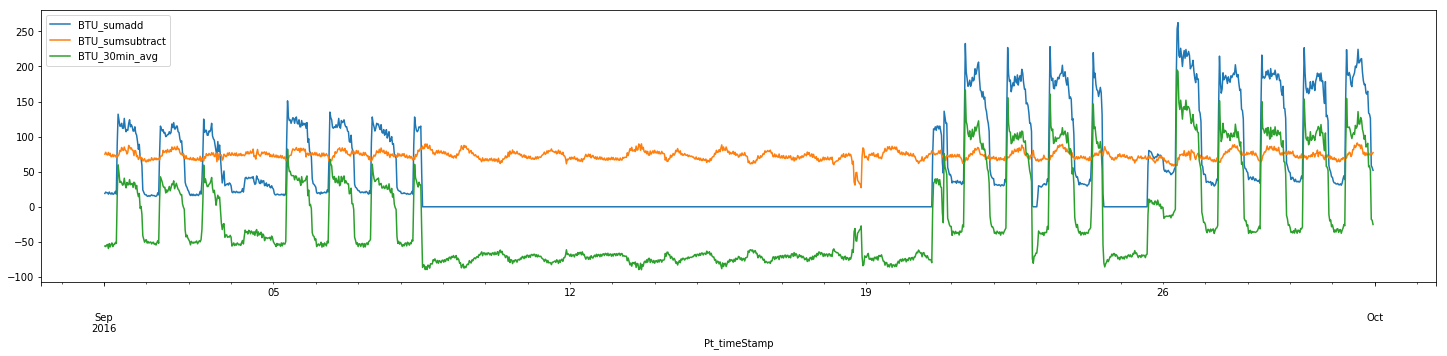

In [29]:
bldg_df_list[4][1].loc['2016-09-01 00:00:00':'2016-09-30 23:30:00', ['BTU_sumadd', 'BTU_sumsubtract', 'BTU_30min_avg']].plot(figsize=(25, 5))

BTUEA1 and BTUEA2 differenced values are zero during 9-21 Sep 16 because their cumulative values are constant (above plot and below table). This produces negative values for aggregate BTU.

In [30]:
bldg_df_list[4][1].loc['2016-09-08 00:00:00':'2016-09-09 23:30:00', ['BTUEA1', 'BTUEA2', 'BTUEA1_30min_avg','BTUEA2_30min_avg', 'BTU_sumadd']]

,BTUEA1,BTUEA2,BTUEA1_30min_avg,BTUEA2_30min_avg,BTU_sumadd
Pt_timeStamp,,,,,
2016-09-08 00:00:00,2746031.25,10693502.0,0.0,22.0,22.0
2016-09-08 00:30:00,2746031.25,10693521.0,0.0,19.0,19.0
2016-09-08 01:00:00,2746031.25,10693540.0,0.0,19.0,19.0
2016-09-08 01:30:00,2746031.25,10693559.0,0.0,19.0,19.0
2016-09-08 02:00:00,2746031.25,10693579.0,0.0,20.0,20.0
2016-09-08 02:30:00,2746031.25,10693598.0,0.0,19.0,19.0
2016-09-08 03:00:00,2746031.25,10693617.0,0.0,19.0,19.0
2016-09-08 03:30:00,2746031.25,10693635.0,0.0,18.0,18.0
2016-09-08 04:00:00,2746031.25,10693654.0,0.0,19.0,19.0


## S1A

In [31]:
bldg_df_list[6][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62880 entries, 2015-06-01 00:00:00 to 2018-12-31 23:30:00
Data columns (total 17 columns):
PWMS1AIC1                           46150 non-null float64
PWMS1AIC2                           46150 non-null float64
PWMAHULevel1                        46150 non-null float64
PWMNewPharmacyEXTLTSWB              44593 non-null float64
PWMS1MainIC1                        46170 non-null float64
BTUS1A                              46150 non-null float64
PWMS1AIC1_30min_avg                 46103 non-null float64
PWMS1AIC2_30min_avg                 46103 non-null float64
PWMAHULevel1_30min_avg              46103 non-null float64
PWMNewPharmacyEXTLTSWB_30min_avg    44458 non-null float64
PWMS1MainIC1_30min_avg              46112 non-null float64
BTUS1A_30min_avg                    46103 non-null float64
PWM_sumadd                          46103 non-null float64
PWM_sumsubtract                     44331 non-null float64
PWM_30min_avg                 

### Examine some potential outlier values

Text(0.5,1,'S1A Cumulative BTU')

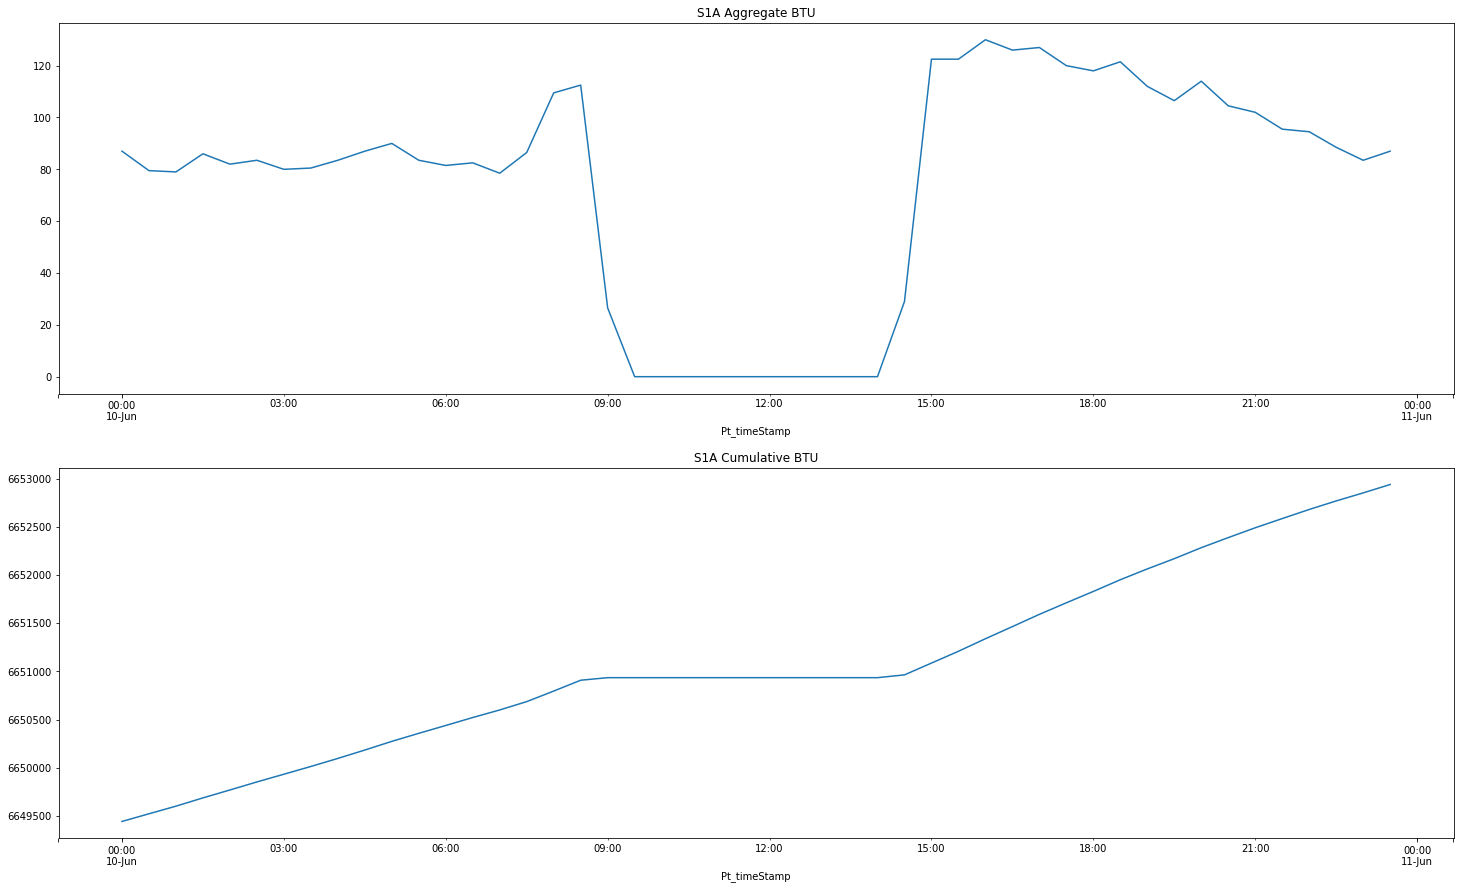

In [32]:
plt.figure(figsize=(25, 15))
plt.subplot(211)
bldg_df_list[6][1].loc['2016-06-10 00:00:00':'2016-06-10 23:30:00', 'BTU_30min_avg'].plot()
plt.title('S1A Aggregate BTU')
plt.subplot(212)
bldg_df_list[6][1].loc['2016-06-10 00:00:00':'2016-06-10 23:30:00', 'BTUS1A'].plot()
plt.title('S1A Cumulative BTU')

The aggregate BTU of value zero look like valid values, given the cumulative BTU values.

Text(0.5,1,'S1A Cumulative BTU')

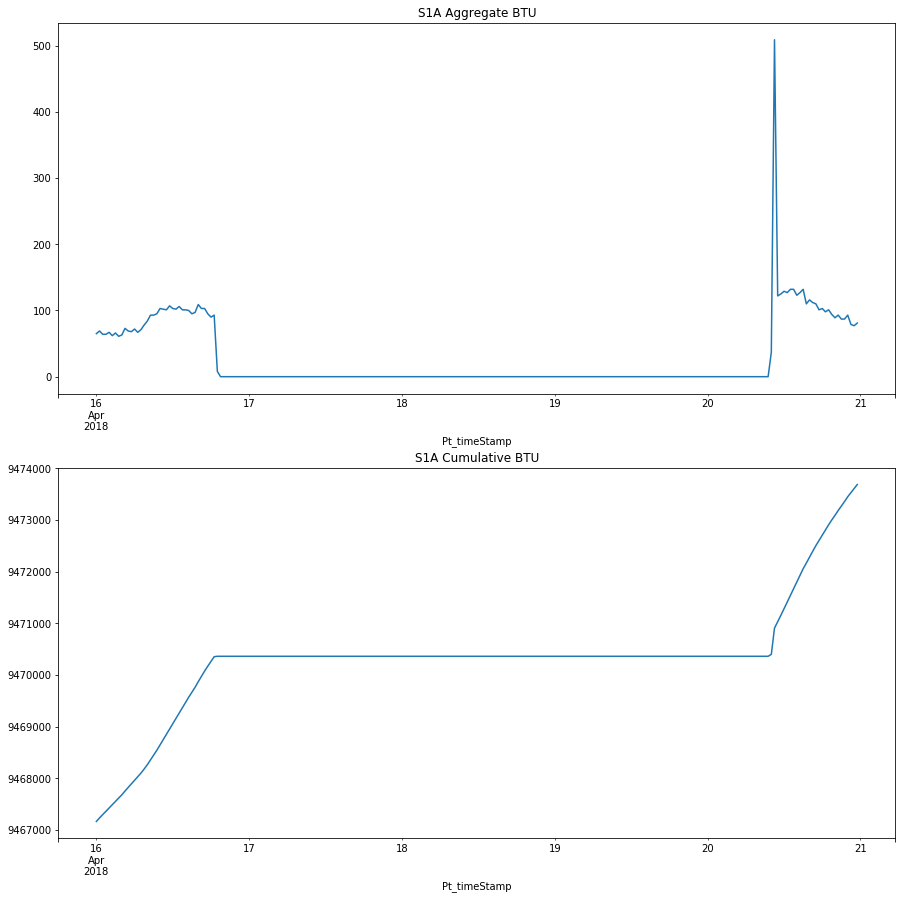

In [33]:
plt.figure(figsize=(15, 15))
plt.subplot(211)
bldg_df_list[6][1].loc['2018-04-16 00:00:00':'2018-04-20 23:30:00', 'BTU_30min_avg'].plot()
plt.title('S1A Aggregate BTU')
plt.subplot(212)
bldg_df_list[6][1].loc['2018-04-16 00:00:00':'2018-04-20 23:30:00', 'BTUS1A'].plot()
plt.title('S1A Cumulative BTU')

The aggregate BTU value at 10:30 is likely an outlier (above plot and below table).

In [34]:
bldg_df_list[6][1].loc['2018-04-20 07:00:00':'2018-04-20 14:00:00', ['BTUS1A', 'BTU_30min_avg']]

,BTUS1A,BTU_30min_avg
Pt_timeStamp,,
2018-04-20 07:00:00,9470362.0,0.0
2018-04-20 07:30:00,9470362.0,0.0
2018-04-20 08:00:00,9470362.0,0.0
2018-04-20 08:30:00,9470362.0,0.0
2018-04-20 09:00:00,9470362.0,0.0
2018-04-20 09:30:00,9470362.0,0.0
2018-04-20 10:00:00,9470399.0,37.0
2018-04-20 10:30:00,9470908.0,509.0
2018-04-20 11:00:00,9471030.0,122.0


### PWM and BTU

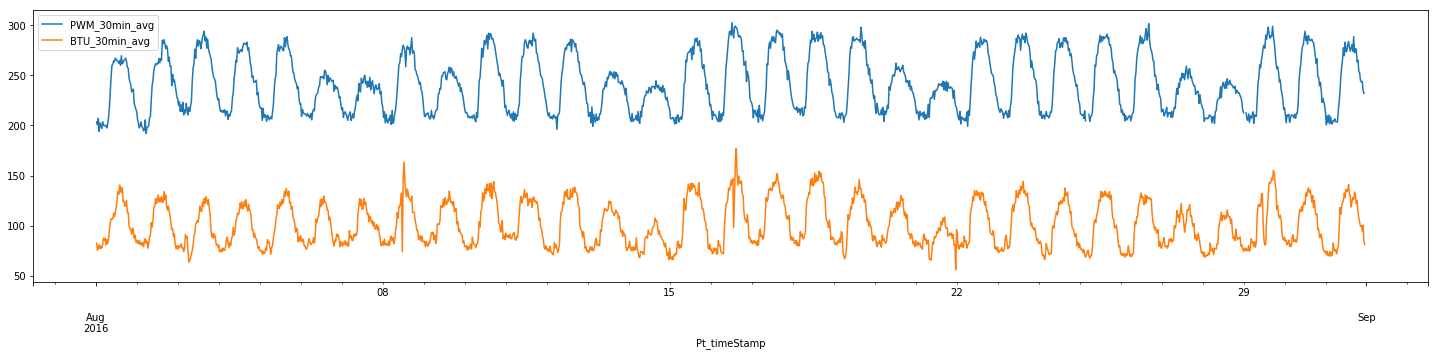

In [35]:
bldg_df_list[6][1].loc['2016-08-01 00:00:00':'2016-08-31 23:30:00', ['PWM_30min_avg', 'BTU_30min_avg']].plot(figsize=(25, 5))

The PWM and BTU data appear to be correlated.

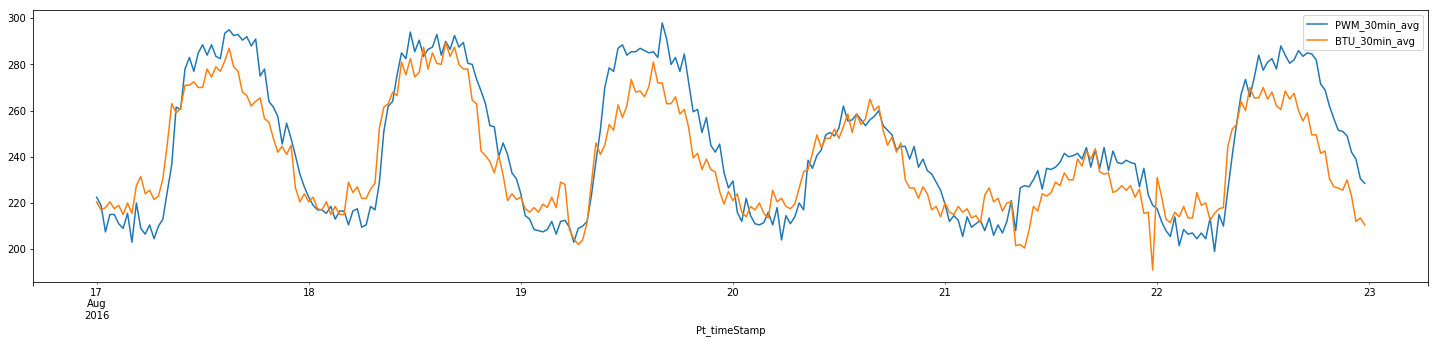

In [36]:
bldg_df_list[6][1].loc['2016-08-17 00:00:00':'2016-08-22 23:30:00', 'PWM_30min_avg'].plot(figsize=(25, 5))
(bldg_df_list[6][1].loc['2016-08-17 00:00:00':'2016-08-22 23:30:00', 'BTU_30min_avg'] + 135).plot()
plt.legend()

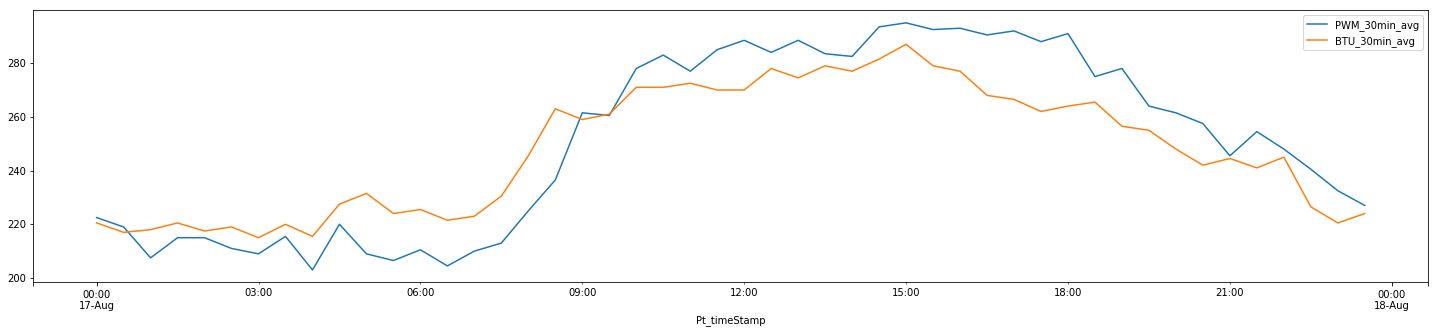

In [37]:
bldg_df_list[6][1].loc['2016-08-17 00:00:00':'2016-08-17 23:30:00', 'PWM_30min_avg'].plot(figsize=(25, 5))
(bldg_df_list[6][1].loc['2016-08-17 00:00:00':'2016-08-17 23:30:00', 'BTU_30min_avg'] + 135).plot()
plt.legend()

BTU appears to lag PWM (~ 30min).

### Pearson's correlation Coefficient

#### For the entire dataset

In [38]:
corr1 = bldg_df_list[6][1]['PWM_30min_avg'].corr(bldg_df_list[6][1]['BTU_30min_avg'])
corr1

0.65257897100196971

In [39]:
corr2 = bldg_df_list[6][1]['PWM_30min_avg'].corr(bldg_df_list[6][1]['BTU_30min_avg'].shift(1))
corr2

In [40]:
(corr2 - corr1) / corr1

0.0076239584061440682

#### For subset without outliers in the BTU data

In [41]:
bldg_df_list[6][1].loc['2016-08-17 00:00:00':'2016-08-22 23:30:00', 'PWM_30min_avg'].corr(bldg_df_list[6][1].loc['2016-08-17 00:00:00':'2016-08-22 23:30:00', 'BTU_30min_avg'])

0.9067035566402154

Pearson's correlation coefficient improves when PWM is compared to BTU lead by 1.

In [42]:
bldg_df_list[6][1].loc['2016-08-17 00:00:00':'2016-08-22 23:30:00', 'PWM_30min_avg'].corr(bldg_df_list[6][1].loc['2016-08-17 00:00:00':'2016-08-22 23:30:00', 'BTU_30min_avg'].shift(1))

0.92386971689925623

## Load Group 2 Building Data

In [43]:
to_load_file = open(os.path.join('source', 'other_data', 'group2_bldg_list.pickle'), 'rb')
group2_bldgs = pickle.load(to_load_file)
group2_bldgs.sort()
group2_bldgs

['AS1',
 'AS2',
 'AS3',
 'AS6',
 'AS7',
 'AS8',
 'Alumni House',
 'BIZ 2',
 'Block B',
 'Brenner Center of Molecular Medicine',
 'CAPT',
 'CELC',
 'CJK Law Library',
 'COM1',
 'COM2',
 'Central Library',
 'Central Library Annex',
 'Cinnamon',
 'Computer Center',
 'Create',
 'Dentistry',
 'E1',
 'E1A',
 'E2',
 'E3',
 'E3A',
 'E4A',
 'E5',
 'EDIC',
 'ERC',
 'ETS Building',
 'EW1',
 'EW2',
 'Eusoff Hall',
 'Federal Building',
 'Graduate Residence',
 'HSE15',
 'HSSML',
 'I-Cube',
 'ISS',
 'KE 7 Hall',
 'KR Hall',
 'Kuok Foundation House',
 'LKCNHM',
 'Li Ka Shing Building',
 'MD1',
 'MD10',
 'MD11',
 'MD2',
 'MD3',
 'MD4andMD4a',
 'MD6',
 'MD7',
 'MD9',
 'MM Building',
 'NUS Centre of Arts',
 'NUS Museum',
 'OCS',
 'OTH',
 'PGPR',
 'RC4',
 'Raffles Hall',
 'Ridge View',
 'Ridge View Residence',
 'S1',
 'S10',
 'S11',
 'S12',
 'S13',
 'S14',
 'S15',
 'S16',
 'S17',
 'S2',
 'S2S',
 'S3',
 'S4',
 'S4A',
 'S5',
 'S6',
 'S7',
 'S8',
 'SRC',
 'SSLS',
 'Sheares Hall',
 'Sports and Recreation Cent

In [44]:
bldg_df_list2 = mu.load_data_by_bldg(bldg_name_list=group2_bldgs[:10], data_type='processed')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  app.launch_new_instance()
/usr/lib/python3/dist-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexin

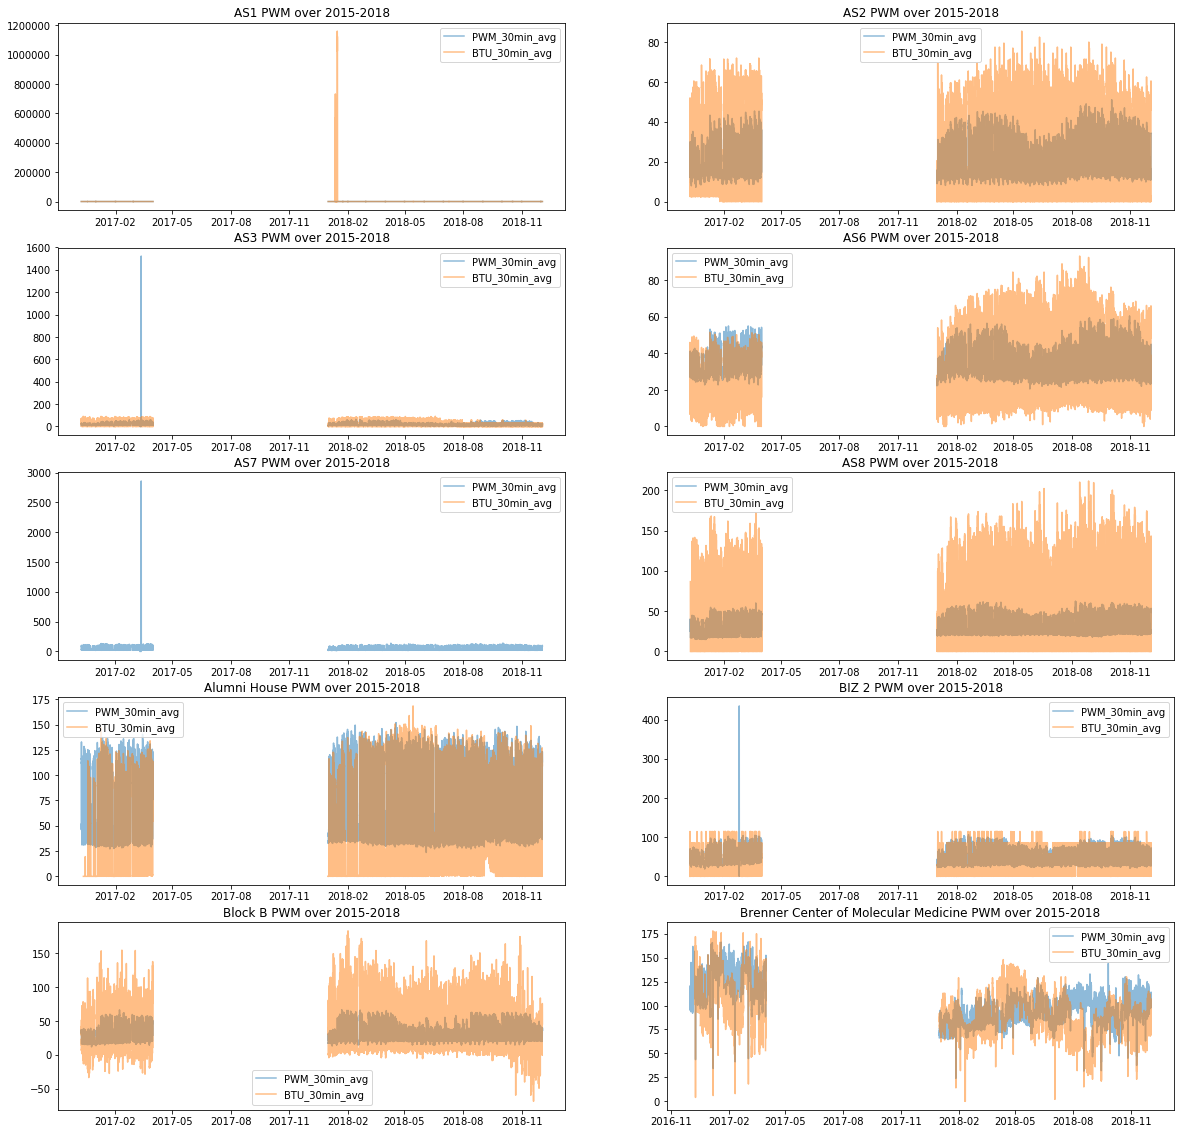

In [45]:
plot_pwm_upto10_bldgs(bldg_df_list2)

BTU in the group 2 buildings appear to have the same issues as group 1 buildings.

## Explore Outlier Detection

### E4 Outlier Using the Inter-quartile Range Method

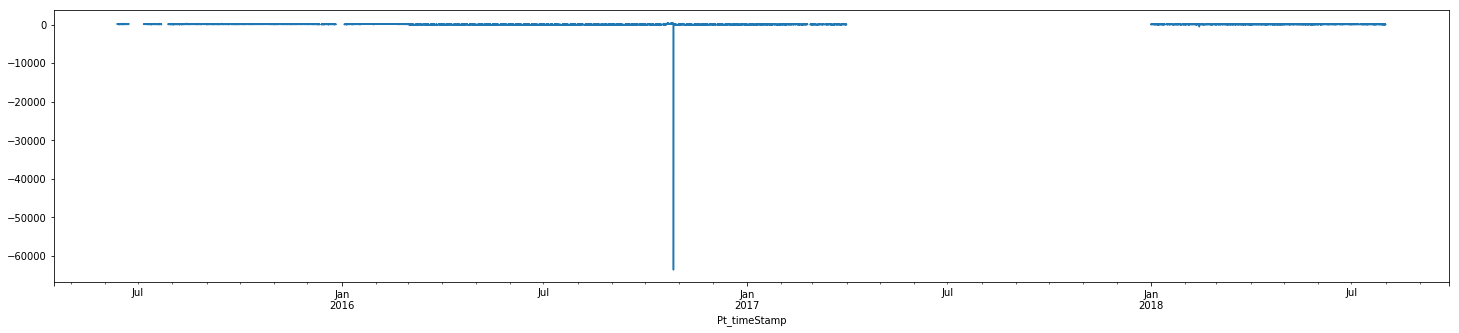

In [46]:
bldg_df_list[3][1]['BTU_30min_avg'].plot(figsize=(25, 5))

In [47]:
q1 = bldg_df_list[3][1]['BTU_30min_avg'].quantile(.25)
q3 = bldg_df_list[3][1]['BTU_30min_avg'].quantile(.75)
iqr = bldg_df_list[3][1]['BTU_30min_avg'].quantile(.75) - bldg_df_list[3][1]['BTU_30min_avg'].quantile(.25)
iqr

71.75

In [48]:
iqr15_idx = bldg_df_list[3][1].index[
    (bldg_df_list[3][1]['BTU_30min_avg'] < (q1 - 1.5 * iqr)) | (bldg_df_list[3][1]['BTU_30min_avg'] > (q3 + 1.5 * iqr))]
iqr15_idx

DatetimeIndex(['2015-06-12 11:30:00', '2015-06-12 16:30:00',
               '2015-06-12 17:00:00', '2015-06-15 10:30:00',
               '2015-06-15 11:00:00', '2015-06-15 12:30:00',
               '2015-06-15 13:00:00', '2015-06-15 13:30:00',
               '2015-06-15 14:00:00', '2015-06-15 16:30:00',
               ...
               '2016-10-26 14:30:00', '2016-10-26 15:00:00',
               '2016-10-26 15:30:00', '2016-10-26 16:00:00',
               '2018-02-13 16:30:00', '2018-02-13 17:00:00',
               '2018-02-13 17:30:00', '2018-03-10 08:30:00',
               '2018-04-12 08:00:00', '2018-04-14 08:30:00'],
              dtype='datetime64[ns]', name='Pt_timeStamp', length=863, freq=None)

In [49]:
iqr3_idx = bldg_df_list[3][1].index[
    (bldg_df_list[3][1]['BTU_30min_avg'] < (q1 - 3.0 * iqr)) | (bldg_df_list[3][1]['BTU_30min_avg'] > (q3 + 3.0 * iqr))]
iqr3_idx

DatetimeIndex(['2015-08-13 15:00:00', '2016-10-20 16:30:00',
               '2016-10-20 17:00:00', '2016-10-20 17:30:00',
               '2016-10-20 18:00:00', '2016-10-20 18:30:00',
               '2016-10-20 19:00:00', '2016-10-20 19:30:00',
               '2016-10-20 20:00:00', '2016-10-21 07:30:00',
               '2016-10-21 08:00:00', '2016-10-21 08:30:00',
               '2016-10-21 09:30:00', '2016-10-21 11:00:00',
               '2016-10-21 11:30:00', '2016-10-21 12:00:00',
               '2016-10-21 12:30:00', '2016-10-21 13:00:00',
               '2016-10-21 13:30:00', '2016-10-21 14:00:00',
               '2016-10-21 14:30:00', '2016-10-21 15:00:00',
               '2016-10-21 15:30:00', '2016-10-21 16:00:00',
               '2016-10-21 16:30:00', '2016-10-21 17:00:00',
               '2016-10-21 17:30:00', '2016-10-21 18:00:00',
               '2016-10-21 18:30:00', '2016-10-21 20:00:00',
               '2016-10-22 08:30:00', '2016-10-22 10:30:00',
               '2016-10-

In [50]:
bldg_df_list[3][1].loc[iqr3_idx, 'BTU_30min_avg']

Pt_timeStamp
2015-08-13 15:00:00      350.00
2016-10-20 16:30:00      368.00
2016-10-20 17:00:00      373.12
2016-10-20 17:30:00      389.50
2016-10-20 18:00:00      356.50
2016-10-20 18:30:00      357.25
2016-10-20 19:00:00      396.88
2016-10-20 19:30:00      367.25
2016-10-20 20:00:00      357.75
2016-10-21 07:30:00      343.38
2016-10-21 08:00:00      367.87
2016-10-21 08:30:00      365.75
2016-10-21 09:30:00      344.63
2016-10-21 11:00:00      367.00
2016-10-21 11:30:00      366.75
2016-10-21 12:00:00      381.75
2016-10-21 12:30:00      411.37
2016-10-21 13:00:00      402.38
2016-10-21 13:30:00      401.25
2016-10-21 14:00:00      386.75
2016-10-21 14:30:00      405.50
2016-10-21 15:00:00      441.12
2016-10-21 15:30:00      422.25
2016-10-21 16:00:00      452.50
2016-10-21 16:30:00      416.63
2016-10-21 17:00:00      425.37
2016-10-21 17:30:00      432.00
2016-10-21 18:00:00      393.13
2016-10-21 18:30:00      373.00
2016-10-21 20:00:00      342.25
                         ..

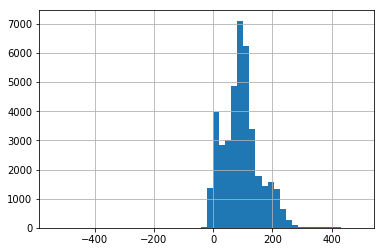

In [51]:
bldg_df_list[3][1].loc[bldg_df_list[3][1]['BTU_30min_avg'] > -60000, 'BTU_30min_avg'].hist(bins=50)

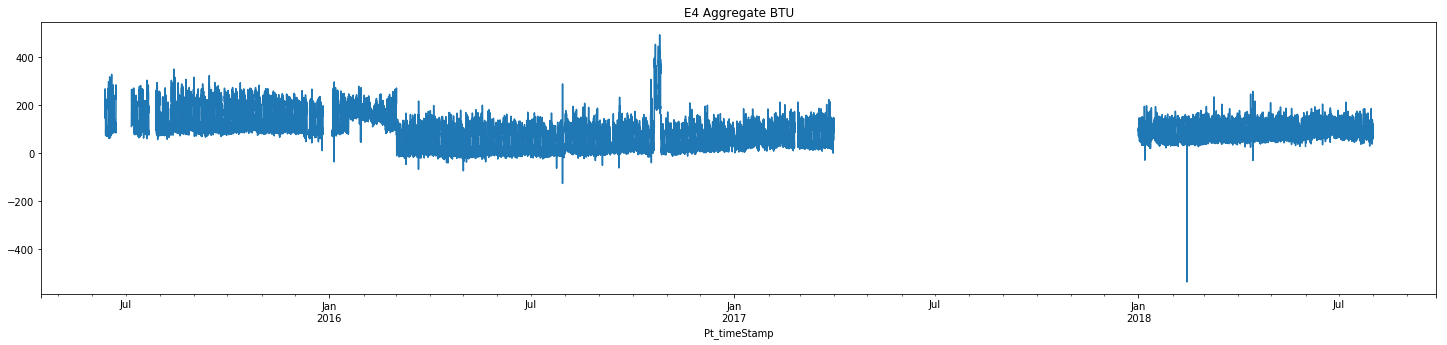

In [52]:
bldg_df_list[3][1].loc[bldg_df_list[3][1]['BTU_30min_avg'] < -60000, 'BTU_30min_avg'] = np.NaN
bldg_df_list[3][1]['BTU_30min_avg'].plot(figsize=(25, 5), title='E4 Aggregate BTU')

#### IQR 3.0

(-575, 525)

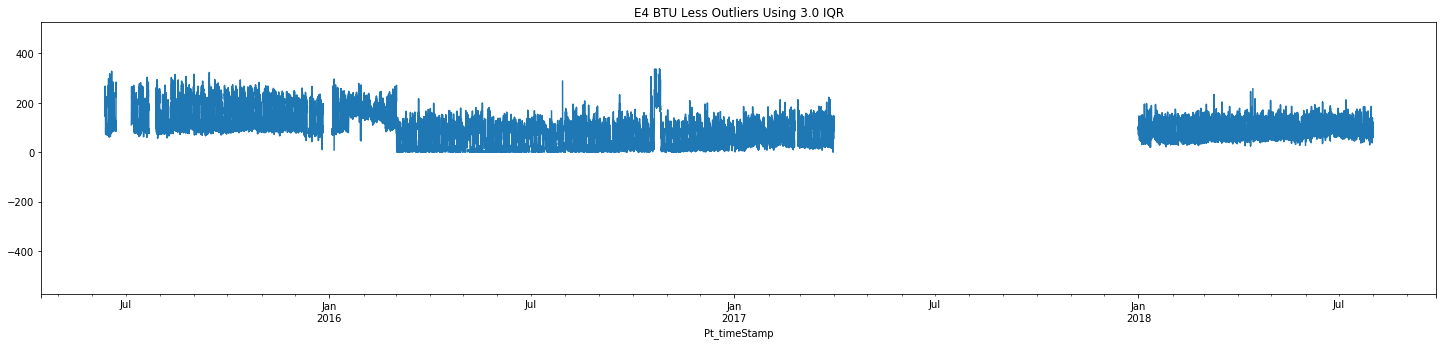

In [53]:
iqr3_data = bldg_df_list[3][1]['BTU_30min_avg'].copy()
iqr3_data[iqr3_idx] = np.NaN
iqr3_data[iqr3_data < 0] = np.NaN

iqr3_data.plot(figsize=(25, 5), title = 'E4 BTU Less Outliers Using 3.0 IQR')
plt.ylim((-575, 525))

(-60, 285)

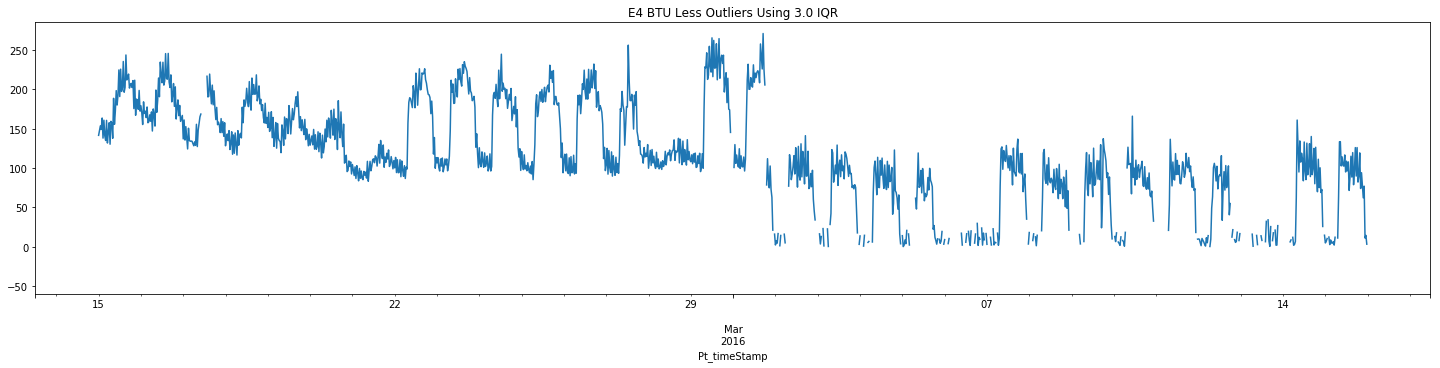

In [54]:
iqr3_data['2016-02-15 00:00:00':'2016-03-15 23:30:00'].plot(figsize=(25, 5), title = 'E4 BTU Less Outliers Using 3.0 IQR')
plt.ylim((-60, 285))

Negative aggregate BTU values were removed in the above plot (compare with below plot).

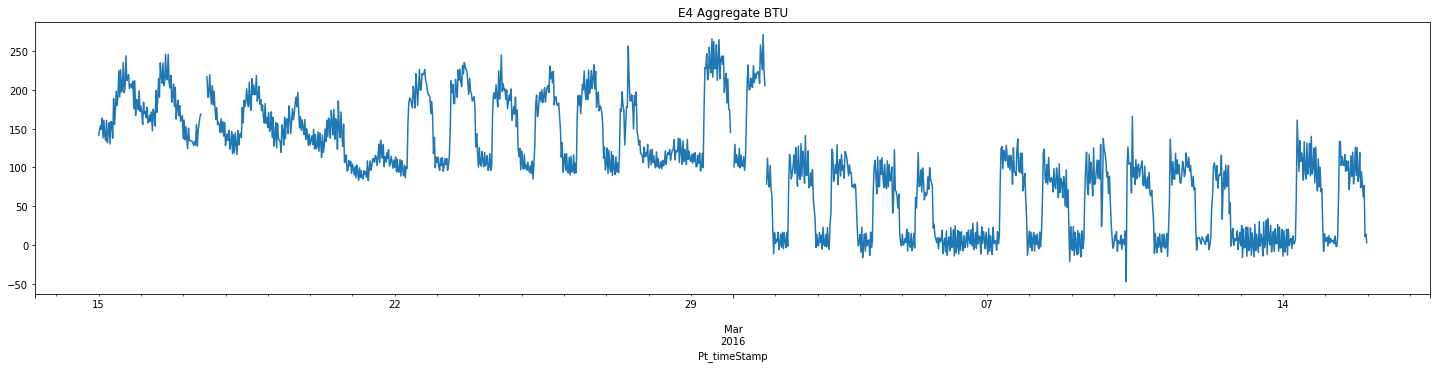

In [55]:
bldg_df_list[3][1].loc['2016-02-15 00:00:00':'2016-03-15 23:30:00', 'BTU_30min_avg'].plot(figsize=(25, 5), title='E4 Aggregate BTU')

On 1 Mar 16, BTUEW2 abruptly become non-zero (below table). This caused a sudden change in aggregate BTU values (above plot and below table).

In [56]:
bldg_df_list[3][1].loc['2016-03-01 14:00:00':'2016-03-02 08:00:00', ['BTUE4_30min_avg', 'BTUE4A_30min_avg', 'BTUEW2_30min_avg', 'BTUE5_30min_avg', 'BTULinkway_30min_avg', 'BTU_30min_avg']]

,BTUE4_30min_avg,BTUE4A_30min_avg,BTUEW2_30min_avg,BTUE5_30min_avg,BTULinkway_30min_avg,BTU_30min_avg
Pt_timeStamp,,,,,,
2016-03-01 14:00:00,725.0,59.50,0.00,180.00,262.0,223.50
2016-03-01 14:30:00,707.0,61.00,0.00,175.25,250.0,220.75
2016-03-01 15:00:00,709.0,58.50,0.00,183.25,259.0,208.25
2016-03-01 15:30:00,737.0,60.00,0.00,176.50,243.0,257.50
2016-03-01 16:00:00,728.0,63.00,0.00,175.25,248.0,241.75
2016-03-01 16:30:00,729.0,60.00,0.00,183.25,260.0,225.75
2016-03-01 17:00:00,761.0,62.25,0.00,175.00,253.0,270.75
2016-03-01 17:30:00,719.0,60.00,0.00,182.00,252.0,225.00
2016-03-01 18:00:00,696.0,58.75,3.25,172.50,256.0,205.50


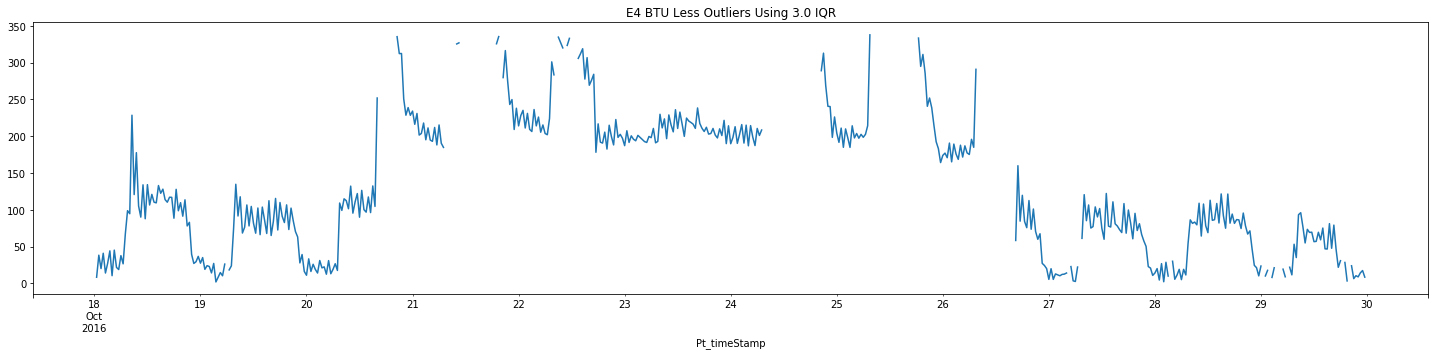

In [57]:
iqr3_data['2016-10-18 00:00:00':'2016-10-29 23:30:00'].plot(figsize=(25, 5), title = 'E4 BTU Less Outliers Using 3.0 IQR')

On 20 Oct 16, BTULinkway abruptly become zero (below table). This caused a sudden increase in aggregate BTU values (above plot and below table).

In [58]:
bldg_df_list[3][1].loc['2016-10-20 12:00:00':'2016-10-21 11:30:00', ['BTUE4_30min_avg', 'BTUE4A_30min_avg', 'BTUEW2_30min_avg', 'BTUE5_30min_avg', 'BTULinkway_30min_avg', 'BTU_30min_avg']]

,BTUE4_30min_avg,BTUE4A_30min_avg,BTUEW2_30min_avg,BTUE5_30min_avg,BTULinkway_30min_avg,BTU_30min_avg
Pt_timeStamp,,,,,,
2016-10-20 12:00:00,748.0,67.50,123.50,183.0,284.0,90.00
2016-10-20 12:30:00,768.0,63.00,113.50,187.0,278.0,126.50
2016-10-20 13:00:00,730.0,60.75,111.00,180.0,278.0,100.25
2016-10-20 13:30:00,740.0,64.50,123.63,181.0,274.0,96.87
2016-10-20 14:00:00,768.0,62.00,122.00,186.5,280.0,117.50
2016-10-20 14:30:00,732.0,64.75,124.50,180.5,266.0,96.25
2016-10-20 15:00:00,774.0,64.25,121.75,185.5,270.0,132.50
2016-10-20 15:30:00,748.0,63.25,119.62,178.5,282.0,104.63
2016-10-20 16:00:00,740.0,65.50,121.50,181.0,120.0,252.00


#### IQR 1.5

(-575, 525)

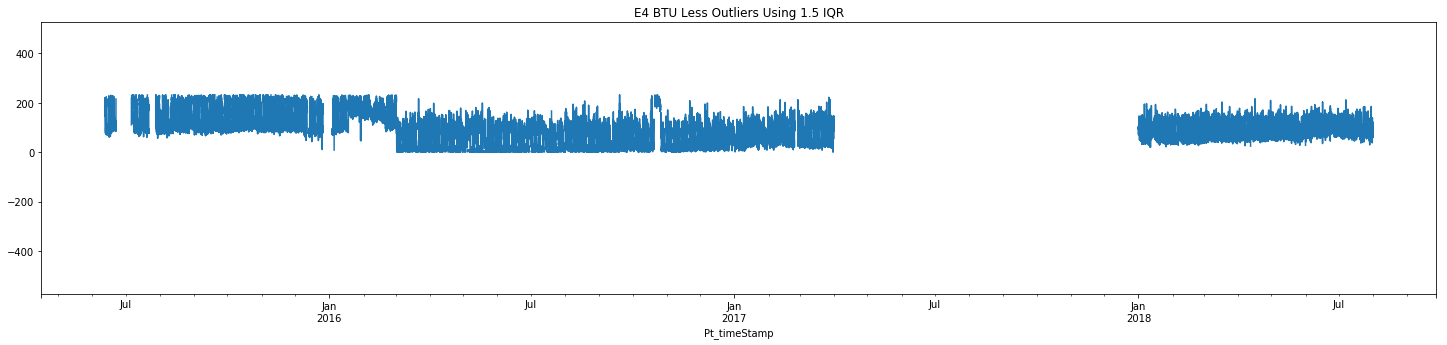

In [59]:
iqr15_data = bldg_df_list[3][1]['BTU_30min_avg'].copy()
iqr15_data[iqr15_idx] = np.NaN
iqr15_data[iqr15_data < 0] = np.NaN

iqr15_data.plot(figsize=(25, 5), title = 'E4 BTU Less Outliers Using 1.5 IQR')
plt.ylim((-575, 525))

### S1A Outlier Using the Inter-quartile Range Method

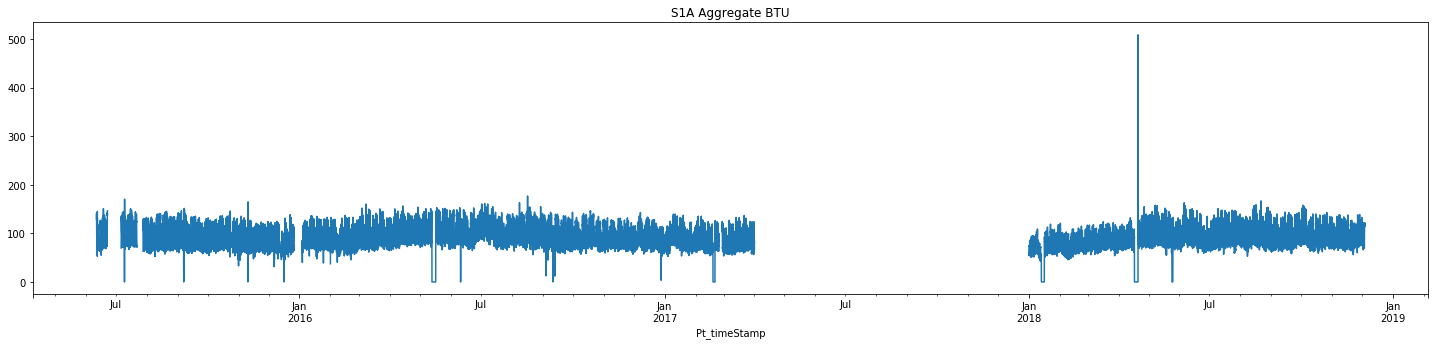

In [60]:
bldg_df_list[6][1]['BTU_30min_avg'].plot(figsize=(25, 5), title = 'S1A Aggregate BTU')

In [61]:
q1 = bldg_df_list[6][1]['BTU_30min_avg'].quantile(.25)
q3 = bldg_df_list[6][1]['BTU_30min_avg'].quantile(.75)
iqr = bldg_df_list[6][1]['BTU_30min_avg'].quantile(.75) - bldg_df_list[6][1]['BTU_30min_avg'].quantile(.25)
iqr

34.0

In [62]:
idx = bldg_df_list[6][1].index[(bldg_df_list[6][1]['BTU_30min_avg'] < (q1 - 3.0 * iqr)) | (bldg_df_list[6][1]['BTU_30min_avg'] > (q3 + 3.0 * iqr))]
idx

DatetimeIndex(['2018-04-20 10:30:00'], dtype='datetime64[ns]', name='Pt_timeStamp', freq=None)

In [63]:
bldg_df_list[6][1].loc[idx, 'BTU_30min_avg']

Pt_timeStamp
2018-04-20 10:30:00    509.0
Name: BTU_30min_avg, dtype: float64

In [64]:
bldg_df_list[6][1].loc[idx, 'BTU_30min_avg'] = np.NaN

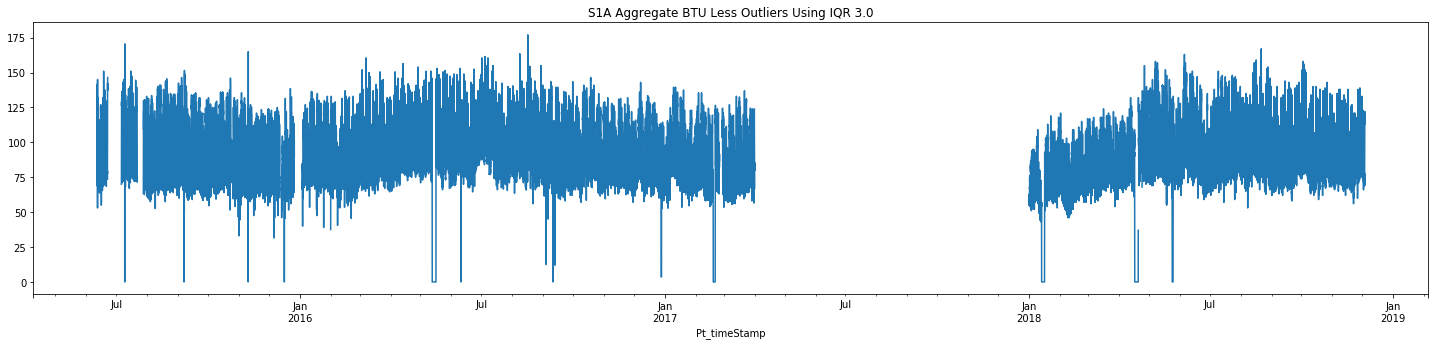

In [65]:
bldg_df_list[6][1]['BTU_30min_avg'].plot(figsize=(25, 5), title = 'S1A Aggregate BTU Less Outliers Using IQR 3.0')